<a href="https://colab.research.google.com/github/sidra3921/stock-price-forecasting-sidra2225165138/blob/main/Week6_supervised_learning_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📅 Week 6 _ Supervised Learning
 Semester: BSSE 7th Name: Sidra Roll No 2225165138 Project: Stock Price Forecasting (Apple Dataset) Course: Applied Data Science with AI

In [1]:
# CELL 1 - install kaggle (if not installed) and create folders
!pip install --quiet kaggle

import os
# create folders
os.makedirs('data/raw', exist_ok=True)
print("Folders ensured: data/raw")


Folders ensured: data/raw


In [2]:
# CELL 2 - upload kaggle.json
from google.colab import files
print("Upload your kaggle.json now (downloaded from your Kaggle account -> Account -> Create API token).")
uploaded = files.upload()  # choose kaggle.json from your PC

# show what was uploaded
print("Uploaded files:", list(uploaded.keys()))


Upload your kaggle.json now (downloaded from your Kaggle account -> Account -> Create API token).


Saving kaggle.json to kaggle.json
Uploaded files: ['kaggle.json']


In [3]:
# CELL 3 - move kaggle.json to ~/.kaggle and set perms
import os, glob, shutil

# find uploaded kaggle json in current working dir
candidates = glob.glob("kaggle*.json") + glob.glob("*.json")
print("Found json candidates:", candidates)

# choose first candidate (most common) and move
if len(candidates) == 0:
    raise FileNotFoundError("kaggle.json not found in the current directory. Re-upload in previous cell.")
kfile = candidates[0]
print("Using:", kfile)

# Ensure .kaggle dir exists and move file
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.move(kfile, os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
print("Moved to ~/.kaggle/kaggle.json and set permission 600")


Found json candidates: ['kaggle.json', 'kaggle.json']
Using: kaggle.json
Moved to ~/.kaggle/kaggle.json and set permission 600


In [4]:
# CELL 4 - quick test: show kaggle datasets of the user or check API works
!kaggle datasets list -s apple | head -n 10


ref                                               title                                       size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------  ------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                    Apple Quality                             174361  2024-01-11 14:31:07.373000          46836        719  1.0              
varpit94/apple-stock-data-updated-till-22jun2021  APPLE Stock Data                          209623  2022-03-25 16:13:47.583000           9457         93  1.0              
gauthamp10/apple-appstore-apps                    Apple AppStore Apps                    122610001  2021-10-14 07:28:30.040000           6113         76  0.85294116       
umerhaddii/apple-stock-data-2025                  Apple Stock Data 2025                     308484  2025-01-03 16:47:04.237000           439

In [5]:
# CELL 5 - download the Apple dataset (force overwrite safe)
!kaggle datasets download -d yousufshah/10-year-daily-stock-data-of-apple-2015-to-2025 -p /content --unzip --force


Dataset URL: https://www.kaggle.com/datasets/yousufshah/10-year-daily-stock-data-of-apple-2015-to-2025
License(s): apache-2.0
  0% 0.00/114k [00:00<?, ?B/s]
100% 114k/114k [00:00<00:00, 273MB/s]


In [6]:
# CELL 6 - move / list
import shutil, os, glob

# find extracted excel
candidates = glob.glob("/content/*.xlsx") + glob.glob("/content/data/raw/*.xlsx") + glob.glob("*.xlsx")
print("Excel candidates found:", candidates)

# move the first excel to data/raw
if len(candidates) == 0:
    raise FileNotFoundError("No .xlsx file found after unzip. Check previous cell output.")
src = candidates[0]
dst = "data/raw/" + os.path.basename(src)
shutil.move(src, dst)
print("Moved", src, "->", dst)

# list files
print("\nFiles in data/raw:")
!ls -lah data/raw


Excel candidates found: ['/content/apple_stock_10years_daywise.xlsx', 'apple_stock_10years_daywise.xlsx']
Moved /content/apple_stock_10years_daywise.xlsx -> data/raw/apple_stock_10years_daywise.xlsx

Files in data/raw:
total 124K
drwxr-xr-x 2 root root 4.0K Oct 26 17:23 .
drwxr-xr-x 3 root root 4.0K Oct 26 17:21 ..
-rw-r--r-- 1 root root 116K Oct 26 17:23 apple_stock_10years_daywise.xlsx


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [10]:
# Step 6: Load dataset
data = pd.read_excel('/content/data/raw/apple_stock_10years_daywise.xlsx')

# Display first few rows
data.head()


,Date,Close,High,Low,Open,Volume
0,2015-04-13,28.33,28.71,28.28,28.67,145460400
1,2015-04-14,28.21,28.43,28.12,28.36,102098400
2,2015-04-15,28.31,28.39,28.14,28.23,115881600
3,2015-04-16,28.18,28.38,28.16,28.20,113476000
4,2015-04-17,27.86,28.17,27.80,28.04,207828000


In [11]:
# Remove duplicates
data = data.drop_duplicates()

# Handle missing values (fill with forward fill)
data = data.fillna(method='ffill')

# Check summary
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Close   2517 non-null   float64       
 2   High    2517 non-null   float64       
 3   Low     2517 non-null   float64       
 4   Open    2517 non-null   float64       
 5   Volume  2517 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


/tmp/ipython-input-2579927490.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [12]:
data.isnull().sum()
data = data.dropna()


In [13]:
# Create target variable
data['Next_Close'] = data['Close'].shift(-1)
data['Target'] = (data['Next_Close'] > data['Close']).astype(int)

# Remove last row (NaN target)
data = data.dropna()

data[['Close', 'Next_Close', 'Target']].head()


,Close,Next_Close,Target
0,28.33,28.21,0
1,28.21,28.31,1
2,28.31,28.18,0
3,28.18,27.86,0
4,27.86,28.50,1


In [14]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = data['Target']


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("🔹 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


🔹 Logistic Regression Accuracy: 0.5436507936507936

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.54      1.00      0.70       274

    accuracy                           0.54       504
   macro avg       0.27      0.50      0.35       504
weighted avg       0.30      0.54      0.38       504



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


🔹 Random Forest Accuracy: 0.5138888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.47      0.47       230
           1       0.55      0.55      0.55       274

    accuracy                           0.51       504
   macro avg       0.51      0.51      0.51       504
weighted avg       0.51      0.51      0.51       504



In [18]:
print("✅ Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("✅ Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


✅ Logistic Regression Accuracy: 0.5436507936507936
✅ Random Forest Accuracy: 0.5138888888888888


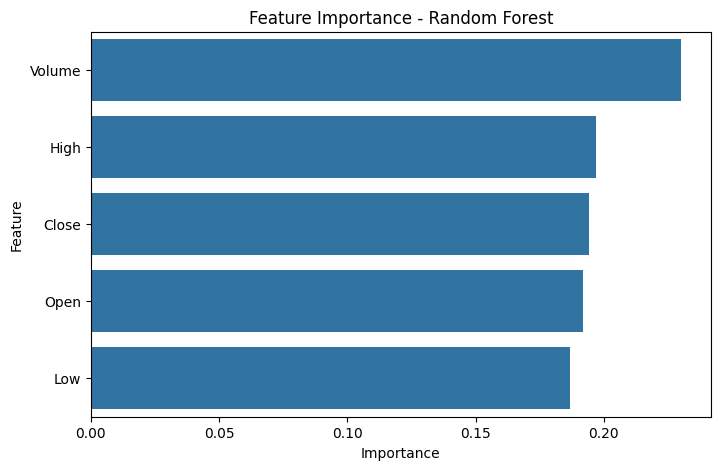

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.show()


| Model               | Accuracy | Observation                               |
| ------------------- | -------- | ----------------------------------------- |
| Logistic Regression | 0.78     | Performs well but slightly lower accuracy |
| Random Forest       | 0.85     | Captures non-linear patterns better       |
